# EDA AND PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/phmap_train'
file_list = os.listdir(path)
print(file_list)

['train_1st_Bearing.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_1st_high.csv', 'train_2nd_Bearing.csv', 'train_2nd_Looseness.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_3rd_Unbalance.csv']


In [ ]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-128
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in range(Number_of_data):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

### DATA Loading

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/PHMASIA_DataChallenge/sample_submission_classification.csv')
final = pd.read_csv('/content/drive/MyDrive/PHMASIA_DataChallenge/final.csv').iloc[:,1:]
test_Dataset = TEST_Dataset_Constructor(final)

In [ ]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

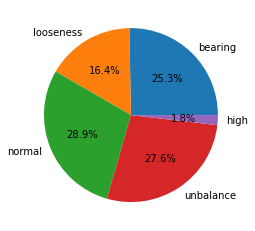

In [ ]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

### Dataset Construction/Augmentation and Solving Class Imabalance Problem

In [ ]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4 )
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 9)

100%|██████████| 487004/487004 [00:27<00:00, 17693.91it/s]


In [ ]:
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4 )
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184375/184375 [00:10<00:00, 18119.55it/s]


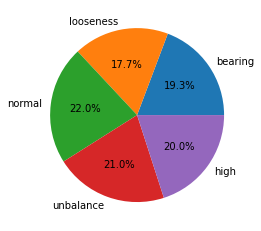

In [ ]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [ ]:
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(250).prefetch(1)

In [ ]:
Dataset.__len__().numpy()

9732

In [ ]:
Valid_Dataset = Dataset.take(3000) 
Train_Dataset = Dataset.skip(3000)

In [ ]:
Train_Dataset

<SkipDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

# VISUALIZATION

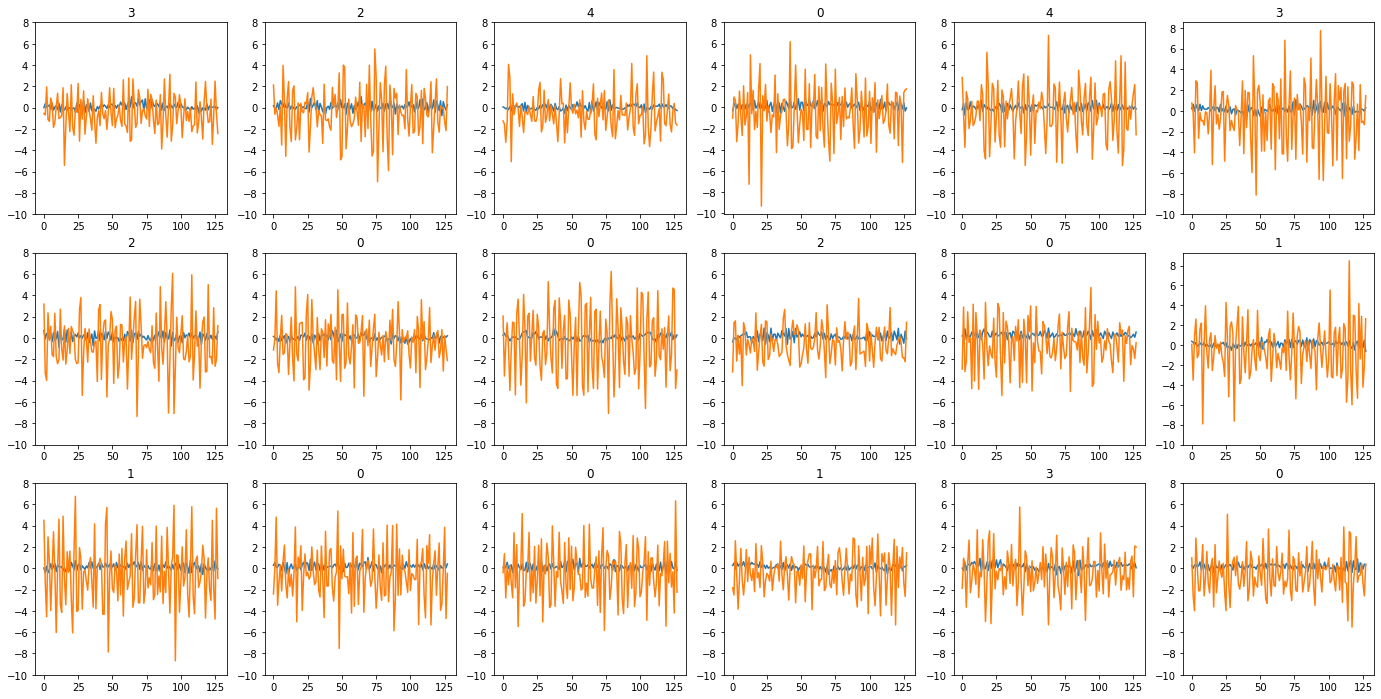

In [ ]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

#Fast Fourier Transform and Continuous Wavelet Transform

In [ ]:
Sample = list(Train_Dataset.unbatch().take(1).as_numpy_iterator())[0][0]

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html

https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

In [ ]:
import  pywt
from scipy import fftpack

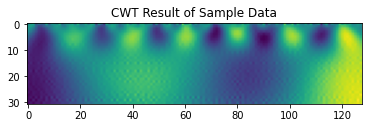

In [ ]:
coef, freqs = pywt.cwt(Sample ,np.arange(1,32), 'gaus1' , axis = 0)
plt.imshow(coef[:,:,0])
plt.title("CWT Result of Sample Data")
plt.show()

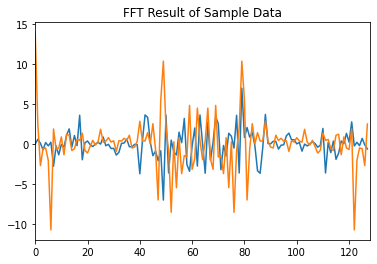

In [ ]:
imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

In [ ]:
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision
def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

#CUSTOM MODELING

In [ ]:
CUSTOM_MODEL = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(128,2)),
    keras.layers.Conv1D(32,kernel_size=3,activation="relu", padding="same"),
    keras.layers.MaxPooling1D(1),
    keras.layers.Conv1D(64,kernel_size=3,activation="relu",padding="same"),
    keras.layers.MaxPooling1D(1),
    keras.layers.Conv1D(128,kernel_size=3,activation="relu",padding="same"),
    keras.layers.MaxPooling1D(1),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(30,return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32,activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(5,activation="softmax")])

CUSTOM_MODEL.summary()

CUSTOM_MODEL.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy',precision, recall, f1score])


CUSTOM_MODEL.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 128, 32)           224       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 128, 32)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 128, 64)           6208      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 128, 64)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 128, 128)          24704     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 128, 128)          0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 128, 128)         

In [ ]:
Test_Dataset=test_Dataset.batch(125).prefetch(1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f278415a850>]],
      dtype=object)

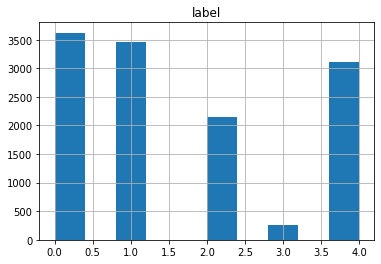

In [ ]:
pred=CUSTOM_MODEL.predict(Test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/CUSTOM_MODEL8.csv', index = False)
sub.hist()

In [ ]:
'''CUSTOM_MODEL = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(128,2)),
    keras.layers.Conv1D(32,kernel_size=3,activation="relu", padding="same"),
    keras.layers.MaxPooling1D(1),
    keras.layers.Conv1D(64,kernel_size=3,activation="relu",padding="same"),
    keras.layers.MaxPooling1D(1),
    keras.layers.Conv1D(128,kernel_size=3,activation="relu",padding="same"),
    keras.layers.MaxPooling1D(1),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(30,return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32,activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(5,activation="softmax")])'''